<!-- dom:TITLE: Figures 4 of the paper on _Quantitative storytelling in the making of a composite indicator_ -->
# Figures 4 of the paper on _Quantitative storytelling in the making of a composite indicator_
<!-- dom:AUTHOR: Samuele Lo Piano at Universitat Oberta de Catalunya, Barcelona -->
<!--
Author: -->  
s.lopiano@gmail.com  
Date: **Aug 03, 2019**

This notebook describes how Figure 4 in the paper _Quantitative storytelling in the making of a composite indicator_ has been 
produced. The layout has been inspired by this [rich collection](https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/?utm_campaign=shareaholic&utm_medium=twitter&utm_source=socialnetwork) of notebooks, which you are warmly invited to browse. The preparation of the _notebook_ as regards Paul Romer's quantitative story telling has been directly retrieved from
his [_GitHub_ repository](https://github.com/paulromer149/DB-Calcs).

## Step 1 - import all the relevant libraries 

This step is essential to develop your code flow.

In [1]:
# Import the pandas library for managing data 

import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

The following passages include the details of Romer's computations to get consistent metrics over the years as to allow to fairly evaluate Chile's world rank of the _Ease of doing business score_.

In [2]:
# Set the notebook so that it can display all countries in a dataframe
#
pd.set_option('display.max_rows', 200)

In [3]:
# Define variables for reading in the data worksheet from the World Bank's Doing Business website
#
data_url = 'http://www.doingbusiness.org/~/media/WBG/DoingBusiness/Documents/Data/DB18-Historical-data-complete-data-with-DTFs.xlsx'
sheet = "All Data"
header_row = 1 # the convention in Python is 0-based indexes; in the worksheet the header is in row 2 
#

In [4]:
# Read the data sheet into a pandas dataframe df
# Use the header to get variable / column names 
# Convert the value 'No Practice' to NaN - not a number 
# 
df = pd.read_excel(data_url,sheet_name = sheet, header = header_row, na_values = ['No Practice'])

In [5]:
# Remove the #-delimiter on the line below, to see rows that include Bangladesh
#
#df[150:200]
#
# It is one of the countries where a second city was added. It is because of these additions 
#    that later there is a cell that drops rows if 
# 
#       "len(df2.loc[i,'code']) != 3"
#  
#    that is, if the code has more or less characters than the 3-letters that were used for the original observations

In [6]:
# Create a dictionary with keys that are the existing variable names and values that are the new names I use

# Note that the import from the excel sheet includes some random line break characters '\n'

rename_variables = {'Country code': 'code', 
                    'DB Year': 'year', 
                    'Procedures - Men (number) ': 's_procs',
                    'Time - Men (days)': 's_time', 
                    'Cost - Men (% of income per capita)': 's_cost', 
                    'Minimum capital (% of income per capita)': 's_min_cap', 
                    'Procedures (number)': 'cn_procs', 'Time (days)': 'cn_time', 
                    'Cost (% of Warehouse value)': 'cn_cost', 
                    'Procedures (number).1': 'e_procs', 
                    'Time (days).1': 'e_time', 
                    'Cost (% of income per capita)': 'e_cost', 
                    'Procedures (number).2': 'rp_procs', 
                    'Time (days).2': 'rp_time', 
                    'Cost (% of property value)': 'rp_cost', 
                    'Strength of legal rights index (0-12) (DB15-18 methodology) ': 'ct_s', 
                    'Depth of credit information index (0-8) (DB15-18 methodology) ': 'ct_d', 
                    'Extent of conflict of interest regulation index (0-10)\n(DB15-18 methodology) ':'pm_cft', 
                    'Extent of shareholder governance index (0-10) (DB15-18 methodology) ':'pm_gv', 
                    'Payments (number per year)': 't_p', 'Time (hours per year)': 
                    't_t', 'Total tax rate (% of profit)': 't_tr', 
                    'Time (days).3': 'en_time', 
                    'Cost (% of claim)': 'en_cost', 
                    'Recovery rate (cents on the dollar)': 'ri_r', 
                    'Strength of insolvency framework index (0-16) (DB15-18 methodology)': 'ri_s'
                   }

# Treat the variable names as a set so that set subtraction specifies the one to drop
#
all_vars = set(df.columns.values)

# Old_names from for the variables that the code keeps and renames 
old_names = set(rename_variables.keys())

# The implied set of variables to drop
vars_to_drop = all_vars - old_names

# Create a list with the new names for the variables that remain 
new_names = list(rename_variables.values())


In [7]:
# Make an independent copy of the dataframe.
#
# If I want to redo my calculations as I work interactively, I can just re-execute this cell without 
#     reloading the data from the external website
# 
df2 = pd.DataFrame(df.copy(deep = True))


In [8]:
# Convert the set of variables that I will drop from a set to a list 
#
el_2 = list(vars_to_drop)
#
#len(df2.columns.values) # count of variables before the drop 
#
# Drop the variables 
#
df2.drop(el_2, axis = 1, inplace = True)
#
#len(df2.columns.values) # to check the variable count after the drop

In [9]:
# Rename the columns / variables that remain  
#
df2.rename(columns=rename_variables, inplace = True)
#
# To verify that rename and drop affects df2 but not df, uncomment one, then other of next two lines and compare 
#df
#df2

In [10]:
# Drop years before and including 2013 
#
df2.drop(labels = [i for i in df2.index if df2.loc[i,'year'] <= 2013], inplace = True)
#
#len(df2) 

In [11]:
# As noted above, drop recently added extra cities  
# 
df2.drop(labels = [i for i in df2.index if len(df2.loc[i,'code']) != 3], inplace = True)
#
#len(df2)

In [12]:
# Specify a multi-index for the remaining variables 

df2.set_index(['year', 'code'], inplace=True)

#df2 # inspect results 

In [13]:
# Create a separate dataframe to store the normalized or distance to the frontier (DTF) values 
#    for different indicators. 
#
dtf = pd.DataFrame(df2.copy(deep = True))


In [14]:
# Create a list of all the indicators that remain 

el_3 = list(dtf.columns.values)
#el_3
#len(el_3)

In [15]:
# Indicators in high are ones where bigger values are better; opposite for variables in low 
#
high = ['ct_s', 'ct_d', 'pm_cft', 'pm_gv',  'ri_r', 'ri_s' ]
low = ['s_procs', 's_time', 's_cost', 's_min_cap', 'cn_procs', 'cn_time',
       'cn_cost', 'e_procs', 'e_time', 'e_cost', 'rp_procs', 'rp_time',  
       'rp_cost', 't_p', 't_t', 't_tr', 'en_time', 'en_cost']

# len(high) + len(low) 

In [16]:
# This loop calculates the distance to the frontier for the 24 variables that are available in a consistent  
#    form for the years I consider, DB2014-18, or calendar 2013-17. 

# These normalized values are stored in the dtf dataframe. The raw values remainin in the df2 dataframe. 

# The loop defines the distance to the frontier by taking the biggest and smallest values for 
#    each variable in any year from DB years 2014-18. 

# I wrote the code as I did assuming that I would use the max and min in each year; then I found 
#    that they change over time, sometimes substantially. This is the type of issue that I understand only 
#    if I work directly with the data myself. 

# This problem is that the min (worst) value for an indicator can change dramatically based on 
#    what happens in a single country with a very bad business environment. 
#    So I added the two lines that calculate mn_m and mx_m by taking the min and
#    max over all DB years from 2014 to 2018. This decision influences the relative influence that 
#    different indicators have in my results.  

# This is an important point. Suppose that it takes every other country between 10 and 100 days to 
#    to issue a permit, but in one laggard it takes 10,000 days. Then all other countries will have a DTF 
#    score for this indicator in the range 10/10,000 to 100/10,000. In this case, a country that takes only 
#    10 days gets almost no recognition for its better performance relative to a country that takes 100. 

# The DTF value for this permit indicator will be 0.999 for the country that takes 10 days 
#    and 0.990 for the country that takes 100 days. When this indicator is averaged along with 8 or 9 others, 
#    it will have an effect on the overall indicator that is visible only in the third decimal place. It will 
#    be swamped by variation in other indicators. 

# My choice is not one that I would defend as being the right way to determine the relative influence of 
#    different indicators. It underweights indicators with a fat lower (that is worse) tail. I haven't explored 
#    the sensitivity of the results for Chile to alternative choices because I didn't want to be accused of 
#    manipulating the data to get some particular outcome. 

# For my purpose, the choice I made had the advantage that it is arbitrary and leads to rankings for 
#    countries that do not change from year to year because of year to year **changes** in the min (worst) 
#    value of an indicator in some lagging country. My choice ensures that he range from best to worst, 
#    and hence the relative influence of each indicator, stays fixed over all the years that I consider. 

# One of the advantages of making this code available is that it lets others do their own sensitivity analysis
#    with respect to this or any other issue. 

# The approach used by the Doing Business team addresses this concern in a different way. 
#    For most indicators (but not all), they also take the min and max over a five year interval.
#    See the description of their approach here: 

#     http://www.doingbusiness.org/~/media/WBG/DoingBusiness/Documents/Annual-Reports/English/DB18-Chapters/DB18-DTF-and-DBRankings.pdf

# To view the values for the min and max for each variable over all years or year by year, uncomment the 
#    print statements in this loop.  

for i in range(len(el_3)):
    mn = df2.groupby(['year'])[el_3[i]].min()
    #print ('mn = ', mn)
    mn_m = mn.min()
    #print('mn_m ',mn_m)
    mx = df2.groupby(['year'])[el_3[i]].max()
    #print ('mx = ', mx)
    mx_m = mx.max()
    #print('mx_m ',mx_m)
    if el_3[i] in low:
        dtf[el_3[i]] = (mx_m - df2[el_3[i]]) / (mx_m - mn_m)
    else:
        dtf[el_3[i]] = (df2[el_3[i]] - mn_m)  / (mx_m - mn_m)


In [17]:
#df2[4:5]  # Test raw data for visual comparison with Bank numbers from spreadsheet

In [18]:
#dtf[4:5]  # Test dtf or normalized data for comparison with Bank numbers on Afghanistan

In [19]:
# Follow the Bank's hierarchical procedure; average the sub-components of the different indicators

# d_ => prefix that means "distance to ..."
# s => Starting A Business ...
# cn => Construction Permits 
# e => Getting Electricity 
# rp => Registering Property 
# ct => Contract Enforcement 
# pm => Protection for Minority investors
# t => Taxes
# en => Enforcing Contracts 
# ri => Resolving Insolvencies 
d_s = pd.Series((dtf['s_procs'] + dtf['s_time'] + dtf['s_cost'] + dtf['s_min_cap']) / 4)
d_cn = pd.Series((dtf['cn_procs'] + dtf['cn_time'] +  dtf['cn_cost']) / 3)
d_e = pd.Series((dtf['e_procs'] + dtf['e_time'] + dtf['e_cost']) / 3)
d_rp = pd.Series((dtf['rp_procs'] + dtf['rp_time'] + dtf['rp_cost']) / 3)
d_ct = pd.Series((dtf['ct_s'] + dtf['ct_d']) / 2) 
d_pm = pd.Series((dtf['pm_cft'] + dtf['pm_gv']) / 2)
d_t = pd.Series((dtf['t_p'] + dtf['t_t'] + dtf['t_tr']) / 3)
d_en = pd.Series((dtf['en_time'] + dtf['en_cost']) / 2)
d_ri = pd.Series((dtf['ri_r'] + dtf['ri_s']) / 2)

In [20]:
# The overall average across indicators 
# I have 9 here because none of the indicators of trade costs are available for all 5 years 
# It should be easy to tweak the code to include some of the trade indicators but 
#     at the cost of restricting the analysis to the 4 data years 2014 to 2017 

d_DTF = pd.Series((d_s + d_cn + d_e + d_rp + d_ct + d_pm + d_t + d_en + d_ri) / 9)
#d_DTF

In [21]:
df2 = pd.concat([df2, d_s.rename('s'), 
                 d_cn.rename('cn'), 
                 d_e.rename('e'), 
                 d_rp.rename('rp'), 
                 d_ct.rename('ct'), 
                 d_pm.rename('pm'), 
                 d_t.rename('t'), 
                 d_en.rename('en'), 
                 d_ri.rename('ri'), 
                 d_DTF.rename('DTF')], axis=1)
#df2
#len(df2)

In [22]:
df2.dropna(axis = 0, subset = ['DTF'], inplace=True)

In [23]:
#df2
#len(df2)

In [24]:
# Define 5 series, one for each year, indexed by country code
#
d_2018 = pd.Series(df2.loc[2018]['DTF'])
#len(d_2018)
d_2017 = pd.Series(df2.loc[2017]['DTF'])
#len(d_2017)
d_2016 = pd.Series(df2.loc[2016]['DTF'])
#len(d_2016)
d_2015 = pd.Series(df2.loc[2015]['DTF'])
#len(d_2015)
d_2014 = pd.Series(df2.loc[2014]['DTF'])
#len(d_2014)
#

In [25]:
# Create series objects that I can sort, one for each year

df_2018 = pd.DataFrame(d_2018)
dfs_2018 = df_2018.sort_values(by =['DTF'], axis=0, ascending=False, inplace=False, kind='quicksort')
length=len(dfs_2018)
dfs_2018['Rank18']= pd.Series(range(1, length + 1 ,1), index=dfs_2018.index)

df_2017 = pd.DataFrame(d_2017)
dfs_2017 = df_2017.sort_values(by =['DTF'], axis=0, ascending=False, inplace=False, kind='quicksort')
length=len(dfs_2017)
dfs_2017['Rank17']= pd.Series(range(1, length + 1 ,1), index=dfs_2017.index)

df_2016 = pd.DataFrame(d_2016)
dfs_2016 = df_2016.sort_values(by =['DTF'], axis=0, ascending=False, inplace=False, kind='quicksort')
length=len(dfs_2016)
dfs_2016['Rank16']= pd.Series(range(1, length + 1 ,1), index=dfs_2016.index)

df_2015 = pd.DataFrame(d_2015)
dfs_2015 = df_2015.sort_values(by =['DTF'], axis=0, ascending=False, inplace=False, kind='quicksort')
length=len(dfs_2015)
dfs_2015['Rank15']= pd.Series(range(1, length + 1 ,1), index=dfs_2015.index)

df_2014 = pd.DataFrame(d_2014)
dfs_2014 = df_2014.sort_values(by =['DTF'], axis=0, ascending=False, inplace=False, kind='quicksort')
length=len(dfs_2014)
dfs_2014['Rank14']= pd.Series(range(1, length + 1 ,1), index=dfs_2014.index)


In [26]:
# Create a new dataframe object dfs indexed by country code that holds sorted series  
#
# Combine the sorted series into a single dataframe indexed by country 
#
dfs_all = pd.concat([dfs_2014, dfs_2015, dfs_2016, dfs_2017,dfs_2018], axis=1)


C:\Users\Samuele\Downloads\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [27]:
# Print out the data for the row of dfs_all that has the results for Chile
#
dfs_all.loc['CHL']

DTF        0.768501
Rank14    46.000000
DTF        0.768808
Rank15    46.000000
DTF        0.776713
Rank16    49.000000
DTF        0.778045
Rank17    48.000000
DTF        0.782235
Rank18    51.000000
Name: CHL, dtype: float64

## Comparison of Romer's QST rank against the official DBI rank

The official _World Bank_ figures can be dowloaded from [this website](https://www.doingbusiness.org/en/custom-query).

In [29]:
df_old = pd.read_excel('Historical-data---complete-data-with-scores.xlsx',header=1,usecols=[0,1,4,6,7,8,9])

Years are filtered out as to focus on the time range 2014-2018 around which the debate over Chile's rank spread. The scores for individual cities - implemented from the _Doing Business_ report 2015 onwards for countries having more than 100 million habitants - are
excluded in order not to falsify the country's ranks.

In [30]:
df_old=df_old[(df_old['DB Year']>2013)&(df_old['DB Year']<2019)&
              (~df_old['Country code'].isin(['BGD_Chit','BGD','BRA_Rio','BRA','CHN_Beij','CHN',
                                                                 'IND_Delh','IND','IDN','IDN_Sura','JPN_Osak','JPN',
                                                                 'MEX','MEX_Mont','NGA_Kano','NGA','PAK_Laho','PAK',
                                                                 'RUS','RUS_Sai','USA_Losa','USA']))]

Country ranks are eventually obtained from their yearly scores.

In [31]:
df_old.loc[df_old['DB Year']==2014,'rank']=df_old['Ease of doing business score  (DB10-14 methodology)'].rank(ascending=False)
df_old.loc[df_old['DB Year']==2015,'rank']=df_old[df_old['DB Year']==2015]['Ease of doing business score (DB15 methodology)'].rank(ascending=False)
df_old.loc[df_old['DB Year']==2016,'rank']=df_old[df_old['DB Year']==2016]['Ease of doing business score (DB16 methodology)'].rank(ascending=False)
df_old.loc[df_old['DB Year']==2017,'rank']=df_old[df_old['DB Year']==2017]['Ease of doing business score (DB17-19 methodology)'].rank(ascending=False)
df_old.loc[df_old['DB Year']==2018,'rank']=df_old[df_old['DB Year']==2018]['Ease of doing business score (DB17-19 methodology)'].rank(ascending=False)

The following two blocks of codes are aimed to harmonise the datasets as to ease their plot.

In [32]:
dfs_all['Country code']=dfs_all.index
dfs_all = dfs_all.reset_index(drop=True)

In [33]:
df_Romer = pd.melt(dfs_all, id_vars=['Country code'], value_vars=['Rank14', 'Rank15','Rank16','Rank17','Rank18'],
                  var_name='DB Year', value_name='rank')
df_Romer['DB Year']=df_Romer['DB Year'].str.replace('Rank','20').astype(int)
df_Romer = df_Romer.sort_values(by=['Country code','DB Year'])

A color-year mapping is then defined.

In [34]:
color_map = dict(zip(range(2014,2019),colors_list[:5]))
df_Romer['color']=df_Romer['DB Year'].map(color_map)

Chile's ranking is eventually extracted from the datasets.

In [35]:
df_CHL = df_Romer[df_Romer['Country code']=='CHL']

map_rank = dict(zip(df_old[df_old['Country code']=='CHL']['DB Year'],df_old[df_old['Country code']=='CHL']['rank']))

df_CHL['rank DBI']=df_CHL['DB Year'].map(map_rank)

C:\Users\Samuele\Downloads\WPy64-3720\python-3.7.2.amd64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


And the official DBI figures are then compared against Romer's QST are in Figure 4 produced as per the code below. Including only the component indicators consistently available over the time frame inquired produced a less volatile ranks for Chile as Paul Romer remarked in [his blog](https://paulromer.net/doing-business/).

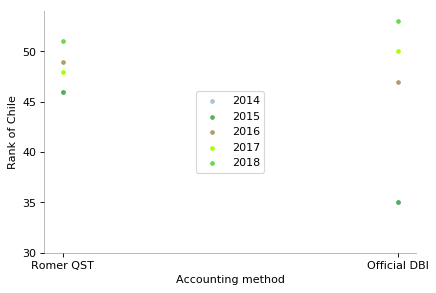

In [45]:
plt.figure(dpi= 80)
for index, row in df_CHL.iterrows():
    plt.scatter('Romer QST',row['rank'], color = row['color'], s=10, label = row['DB Year'])
    plt.scatter('Official DBI',row['rank DBI'], color = row['color'], s=10,label='')
plt.ylabel('Rank of Chile')
plt.xlabel('Accounting method')
plt.ylim(34,54)
plt.xticks(fontsize=10)
plt.yticks(np.arange(30, 55, step=5))
plt.legend(loc='center')
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)
plt.show()